# Spring 2021 Lidar Data
S. Filhol, July 2021


-------
Part 1:  Find out when to convert bin file into DEMs

1. get wind, temperature, flux, precip and snow depth from flux station
2. identify events: precip, wind, transport.
3. create list of timestamp to convert bin to netcdf. High temporal resolution during events, low temporal resolution in low activity

-------
Part 2

1. write code to load files metadata to sort which file to process and post process
2. 

In [1]:
from wsn_client import query
from wsn_client import var_dict

import xarray as xr
import glob
import pandas as pd
import datetime

## 1. Download data from database

In [2]:

start = datetime.datetime(2021,4,7,9)
end = datetime.datetime(2021,6,13,6)

var_oi_mean = ['FC1DRIFTmean_99_99_1_1_1',
          'FC2DRIFTmean_99_99_1_1_1',
          'WD_20_35_1_1_1',
          'WS_16_33_1_1_1',
          'TA_2_1_1_1_1',
          'METNOR_99_99_1_1_1',
          'METNOS_99_99_1_1_1']
var_oi_max = ['FC1DRIFTmax_99_99_1_1_1',
          'FC2DRIFTmax_99_99_1_1_1',
          'WD_20_35_1_1_1',
          'WS_16_33_1_1_1',
          'TA_2_1_1_1_1',
          'METNOR_99_99_1_1_1',
          'METNOS_99_99_1_1_1']

df_mean = query.query('clickhouse', serial=3668, table='finseflux_Biomet',limit=10000000,
                 fields=var_oi_mean, time__gte=start, time_lte=end,
                interval=60*10, interval_agg='mean')
df_max = query.query('clickhouse', serial=3668, table='finseflux_Biomet',limit=10000000,
                 fields=var_oi_max, time__gte=start, time_lte=end,
                interval=60*10, interval_agg='max')

In [19]:
df_mean.columns = [var_dict.CR6_biomet_perm[x] for x in df_mean.columns]
df_max.columns = [var_dict.CR6_biomet_perm[x] for x in df_max.columns]
df_mean.head()

,time,fc1drift_mean,fc2drift_mean,wd,ws,ta,metno_r,metno_s
time,,,,,,,,
2021-04-07 07:00:00,1617778800,0.001167,71.298,297.550000,4.852833,-6.130192,518.687208,NaN
2021-04-07 07:10:00,1617779400,0.001183,71.298,289.983333,5.153667,-6.201749,518.668430,NaN
2021-04-07 07:20:00,1617780000,0.001067,71.298,291.150000,4.574333,-6.170315,518.679520,NaN
2021-04-07 07:30:00,1617780600,0.001717,71.298,297.116667,4.299667,-6.072009,518.680298,50.44
2021-04-07 07:40:00,1617781200,0.006050,71.298,294.983333,4.984000,-6.044804,518.659150,NaN


In [32]:
# Correct data 
# 1. remove precipitation bucket signal
df_max['precip'] = df_max.metno_r.diff()
df_max.precip.loc[df_max.precip<-100] = 0

# 1. remove precipitation bucket signal
df_mean['precip'] = df_max.metno_r.diff()
df_mean.precip.loc[df_max.precip<-100] = 0

# 2. remove bad flowcapt 2 data (flowcapt sensor 2 keeps failing)


/home/simonfi/miniconda3/envs/dataAna/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## 2. Plot and Identification of events

In [20]:
import matplotlib.pyplot as plt

[None, None, None, None]

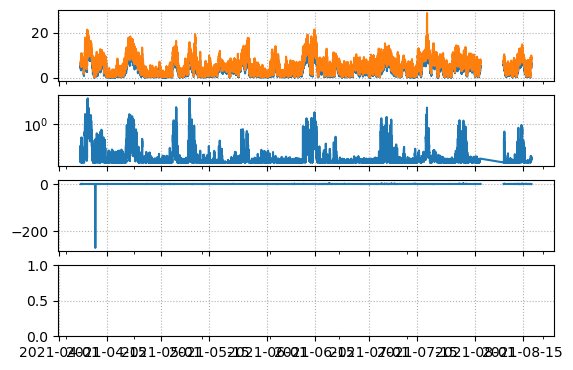

In [31]:
fig, ax = plt.subplots(4,1,sharex=True)

# wind speed panel
df_mean.ws.plot(ax=ax[0], label='Mean')
df_max.ws.plot(ax=ax[0], label='Max')


# flowcapt panel
#(df_mean.fc1drift_mean).plot(ax=ax[1])
ax[1].semilogy(df_mean.fc1drift_mean)

# Precipitation panel
df_max.metno_r.diff().plot(ax=ax[2])

# Temperature 

[x.grid(linestyle=':') for x in ax]

In [23]:
%matplotlib

Using matplotlib backend: Qt5Agg
